In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ,assemble,QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Operator
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
import random
#from tabulate import tabulate
from math import pi
from numpy.random import randint,rand
from statistics import mean, stdev, variance
# Loading your IBM Quantum account(s)
simulator = Aer.get_backend('qasm_simulator')

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [15]:
#Establish 3 bell pair between Alice and Bob
def bell_state(qc,alice):
    for i in alice :
        #key = random.randint(1,4)
        qc.h(i)
        qc.cx(i,i+1)
    qc.barrier()   
    return qc 

def inv_bell_state(qc,alice):
    for i in alice :
        #key = random.randint(1,4)
        qc.cx(i,i+1)
        qc.h(i)
    qc.barrier()   
    return qc     
    

In [16]:
#Message Encoding 
def msg_encoding(msg,qc):
    fst2bit="".join(str(i) for i in msg[0:2])
    lst_bit=msg[2]   

    #print(fst2bit)

    if fst2bit =='00':
        qc.i(0)

    elif fst2bit =='01':
        qc.x(0)

    elif fst2bit =='10':
        qc.x(0)
        qc.z(0)
        
    else:
        qc.z(0)

    if lst_bit==0:    
        qc.i(2)
    if lst_bit==1:

        qc.x(2)

    qc.barrier()
    return qc   

In [17]:
#GHZ Basis measurement 
def ghz_meas(qc,q_list):
    qc.cx(q_list[0],q_list[2])
    qc.cx(q_list[0],q_list[1])
    qc.h(q_list[0])
    return qc     

#Inverse ghz_measurement 
def inv_ghz_meas(qc,q_list):
    qc.h(q_list[0])
    qc.cx(q_list[0],q_list[1])
    qc.cx(q_list[0],q_list[2])
    return qc 

In [18]:
#Function to guess the message from bob and alice outcome 
def guess_msg(bob_out,alic_out):
    ghz_dict={'000':'000+111','001':'001+110','010':'010+101','011':'011+100','100':'000-111','101':'001-110','110':'010-101','111':'011-100'}
    alic=ghz_dict[alic_out]
    bob=ghz_dict[bob_out]
    msg=''
    #print(bob,alic)
    #checking 000 or 001
    if (bob[0]==alic[0] and bob[2]==alic[2] and bob[3]==alic[3]):
        msg+='00'
        if bob[1]==alic[1]:
            msg+='0'
        else:
            msg+='1'
            
    #checking 110 or 111        
    if (bob[0]==alic[0] and bob[2]==alic[2] and bob[3]!=alic[3]):
        msg+='11'
        if bob[1]==alic[1]:
            msg+='0'
        else:
            msg+='1'       
            
            
    #checking 010 or 011        
    if bob[0] !=alic[4] and bob[2]==alic[6] and bob[3]==alic[3] :
        msg+='01'
        if bob[1] ==alic[5]:
            msg+='0'
        else:
            msg+='1'  
            
    #checking 100 or 101        
    if bob[0] !=alic[4] and bob[2]==alic[6] and bob[3]!=alic[3] :
        msg+='10'
        if bob[1] ==alic[5]:
            msg+='0'
        else:
            msg+='1'         
            
    return(msg)

In [19]:
def msg_gss_mlt_shot(result,shots):
    msg_out=[]
    dct={}
    for key in result.keys():
        msg_key=guess_msg(key[:3],key[3:])
        if msg_key in dct.keys():
            dct[msg_key]+=result[key]*1/shots
        else:
            dct[msg_key]=result[key]*1/shots

    msg_out.append(dct)
    return(msg_out)

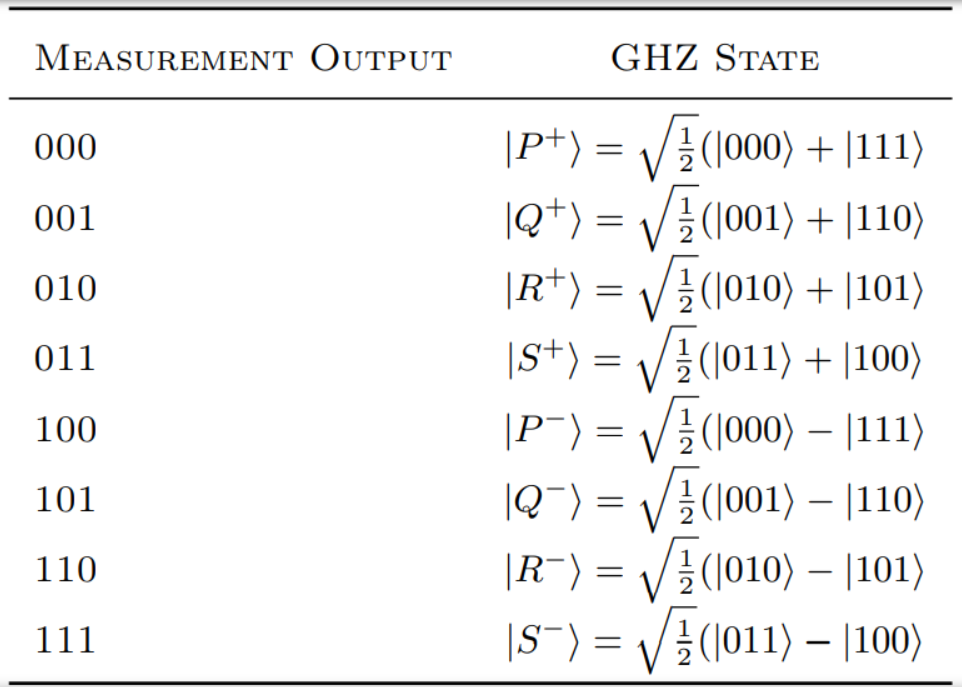

Circuit depth:  12
011
100
---
100


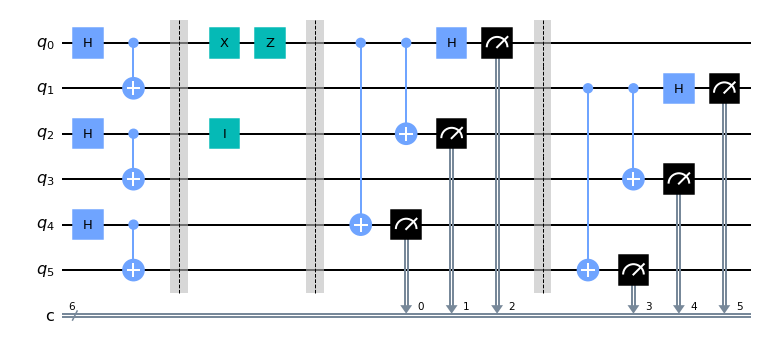

In [20]:
#Complete Protocol for 3 bit message

qc=QuantumCircuit(6,6)
alice=[0,2,4]  #Alice qubit
Bob=[1,3,5]  #Bob qubit

msg=[1,0,0]

qc=bell_state(qc,alice)  
qc=msg_encoding(msg,qc)
qc=ghz_meas(qc,alice)

qc.measure(alice,[2,1,0])
qc.barrier()


#Bob measurement 
qc=ghz_meas(qc,Bob)
qc.measure(Bob,[5,4,3])
print("Circuit depth: ", qc.depth())
Result = simulator.run(qc, shots = 1, memory = True).result()
Bob_out=Result.get_memory()[0][:3]
Alic_out=Result.get_memory()[0][3:]
print(Alic_out)
print(Bob_out)
print('---')
print(guess_msg(Bob_out,Alic_out))
qc.draw()

## Measurement Noise Mittigation

In [61]:
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit import QuantumCircuit, QuantumRegister, Aer, transpile, assemble
from qiskit.visualization import array_to_latex

In [106]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
aer_sim = Aer.get_backend('aer_simulator')

'''
def get_noise(p):

    error_meas = pauli_error([('X',p), ('I', 1 - p)])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
        
    return noise_model'''

'\ndef get_noise(p):\n\n    error_meas = pauli_error([(\'X\',p), (\'I\', 1 - p)])\n\n    noise_model = NoiseModel()\n    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements\n        \n    return noise_model'

In [111]:
# Run this cell if NOISY SIMMULATOR (BIT and PHASE FLIP) is choosen
if True:
    
    
    '''Bit-flip error is one kind of pauli error where with a small probability, p, X gate
    and with probability 1-p identity gate is being applied.
    Phase-flip error is another kind of pauli error where with a small probability, p', Z gate
    and with probability 1-p' identity gate is being applied.
    
    Here bit-flip and phase-flip error is being combined to create noisy model:
        with probability p, Z gate is being applied
        with probability p', X gate is being applied
        with probability 1-p-p', identity gate is being applied
        
        (all qubits have same error probability)'''
    
    # import required loibraries
    from qiskit.providers.aer.noise import NoiseModel
    from qiskit.providers.aer.noise.errors import pauli_error
    from qiskit.providers.aer import QasmSimulator
    
    # Error probability for reset
    x_reset = 0.008 # bit-flip probability
    z_reset = 0.011 # phase-flip probability
    
    # Error probability for measurement
    x_meas = 0.009
    z_meas = 0.013
    
    # Error probability for gate
    x_gate = 0.0004
    z_gate = 0.0005
    
    # QuantumError objects
    error_reset = pauli_error([('Z', z_reset), ('X', x_reset), ('I', 1 - x_reset - z_reset)])
    error_meas = pauli_error([('Z', z_meas), ('X', x_meas), ('I', 1 - x_meas - z_meas)])
    error_gate1 = pauli_error([('Z', z_gate), ('X', x_gate), ('I', 1 - x_gate - z_gate)])
    error_gate2 = error_gate1.tensor(error_gate1)
    
     #print('Reset error:\n', error_reset, '\nMeasurement error:\n', error_meas,
          #'\nSingle-qubit gate error:\n', error_gate1, '\nTwo-qubit gate error:\n', error_gate2)
    
    # Add errors to noise model
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_reset, "reset")
    noise_model.add_all_qubit_quantum_error(error_meas, "measure")
    noise_model.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"])
    
    #backend = QasmSimulator(noise_model = noise_model)
    
    print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u2', 'cx', 'reset', 'u1', 'u3', 'measure']
  All-qubits errors: ['reset', 'measure', 'u1', 'u2', 'u3', 'cx']


In [108]:
qr = QuantumRegister(6)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

In [109]:
# Execute the calibration circuits without noise
t_qc = transpile(meas_calibs, aer_sim)
qobj = assemble(t_qc, shots=10000)
cal_results = aer_sim.run(qobj, shots=10000).result()
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
array_to_latex(meas_fitter.cal_matrix)

<IPython.core.display.Latex object>

In [19]:
#noise_model = get_noise(0.1)

In [112]:
t_qc = transpile(meas_calibs, aer_sim)
qobj = assemble(t_qc, shots=10000)
cal_results = aer_sim.run(qobj, noise_model=noise_model, shots=10000).result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
array_to_latex(meas_fitter.cal_matrix)

<IPython.core.display.Latex object>

In [113]:
t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc, shots=10000)
results = aer_sim.run(qobj, noise_model=noise_model, shots=10000).result()
noisy_counts = results.get_counts()
print(noisy_counts)

{'100000': 67, '110100': 44, '001011': 36, '001000': 42, '110011': 74, '111100': 110, '101111': 38, '001101': 83, '110010': 83, '010110': 72, '000110': 102, '110101': 123, '100111': 117, '011101': 87, '011111': 85, '101100': 32, '110111': 44, '001001': 55, '000111': 803, '111010': 72, '111000': 816, '000000': 53, '101011': 64, '011011': 51, '110110': 57, '100100': 55, '101110': 113, '101000': 84, '001110': 766, '101101': 58, '010010': 54, '001111': 79, '000011': 115, '011110': 82, '110001': 725, '011100': 783, '111011': 87, '001100': 89, '010000': 39, '010101': 732, '000001': 47, '010100': 72, '011000': 113, '100011': 764, '010111': 78, '000100': 78, '010001': 106, '000010': 41, '001010': 118, '111111': 66, '100010': 69, '110000': 74, '111001': 63, '100110': 41, '111101': 39, '011001': 41, '101001': 54, '010011': 45, '000101': 78, '011010': 42, '101010': 736, '111110': 49, '100101': 45, '100001': 70}


In [114]:
print(len(noisy_counts))

64


In [115]:
t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc, shots=10000)
results = aer_sim.run(qobj, noise_model=noise_model, shots=10000).result()
noisy_counts = results.get_counts()
# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts()

In [116]:
print(len(mitigated_counts))
print('---')
print(mitigated_counts)

64
---
{'000000': 53.18376645936269, '000001': 45.2234396375475, '000010': 39.151458190240675, '000011': 105.95476538041714, '000100': 78.45489749140928, '000101': 66.09606714165719, '000110': 89.4004766291329, '000111': 842.9404774035204, '001000': 39.71095327394341, '001001': 55.29710568274458, '001010': 108.55264534341734, '001011': 33.65875803765207, '001100': 75.42479834009707, '001101': 83.50105779560987, '001110': 805.3298666493229, '001111': 66.89006969023913, '010000': 36.85097429335093, '010001': 97.78883991511334, '010010': 54.18479596803306, '010011': 43.50347713876053, '010100': 58.03774248970321, '010101': 769.291903940134, '010110': 72.33969926104103, '010111': 65.3211853092186, '011000': 104.40880418097748, '011001': 38.72917597351683, '011010': 39.956152195183265, '011011': 50.51134944975039, '011100': 823.2828275866324, '011101': 75.69785734566992, '011110': 69.07628143392485, '011111': 85.81883457151282, '100000': 67.17801206199665, '100001': 58.18990522763622, '1000

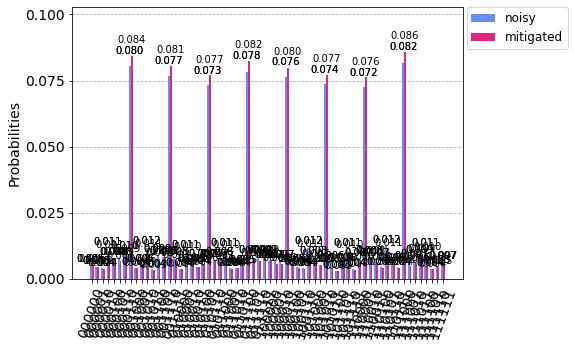

In [117]:
from qiskit.visualization import plot_histogram 
noisy_counts = results.get_counts()
plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])

## Zero Noise Extrapolation 

In [85]:
# Run this cell if NOISY SIMMULATOR (BIT and PHASE FLIP) is choosen
if True:
    
    
    '''Bit-flip error is one kind of pauli error where with a small probability, p, X gate
    and with probability 1-p identity gate is being applied.
    Phase-flip error is another kind of pauli error where with a small probability, p', Z gate
    and with probability 1-p' identity gate is being applied.
    
    Here bit-flip and phase-flip error is being combined to create noisy model:
        with probability p, Z gate is being applied
        with probability p', X gate is being applied
        with probability 1-p-p', identity gate is being applied
        
        (all qubits have same error probability)'''
    
    # import required loibraries
    from qiskit.providers.aer.noise import NoiseModel
    from qiskit.providers.aer.noise.errors import pauli_error
    from qiskit.providers.aer import QasmSimulator
    
    # Error probability for reset
    x_reset = 0.008 # bit-flip probability
    z_reset = 0.011 # phase-flip probability
    
    # Error probability for measurement
    x_meas = 0.009
    z_meas = 0.013
    
    # Error probability for gate
    x_gate = 0.0004
    z_gate = 0.0005
    
    # QuantumError objects
    error_reset = pauli_error([('Z', z_reset), ('X', x_reset), ('I', 1 - x_reset - z_reset)])
    error_meas = pauli_error([('Z', z_meas), ('X', x_meas), ('I', 1 - x_meas - z_meas)])
    error_gate1 = pauli_error([('Z', z_gate), ('X', x_gate), ('I', 1 - x_gate - z_gate)])
    error_gate2 = error_gate1.tensor(error_gate1)
    
     #print('Reset error:\n', error_reset, '\nMeasurement error:\n', error_meas,
          #'\nSingle-qubit gate error:\n', error_gate1, '\nTwo-qubit gate error:\n', error_gate2)
    
    # Add errors to noise model
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_reset, "reset")
    noise_model.add_all_qubit_quantum_error(error_meas, "measure")
    noise_model.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"])
    
    backend = QasmSimulator(noise_model = noise_model)
    
    print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u2', 'u1', 'measure', 'reset', 'cx', 'u3']
  All-qubits errors: ['reset', 'measure', 'u1', 'u2', 'u3', 'cx']


In [90]:
import qiskit
from qiskit import QuantumCircuit
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit import QuantumCircuit, QuantumRegister, Aer, transpile, assemble
from qiskit.visualization import array_to_latex
aer_sim = Aer.get_backend('aer_simulator')
# Noise simulation packages
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error



def qs_noisy_simulation(circuit):

    shots=1000
    
    
    #--------------if there is measurement error ------------------------------
    measure=True
    
    if measure:
        qr = QuantumRegister(6)
        meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')
        t_qc = transpile(meas_calibs, aer_sim)
        qobj = assemble(t_qc, shots=1000)
        cal_results = aer_sim.run(qobj, noise_model=noise_model, shots=1000).result()
        meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
        #array_to_latex(meas_fitter.cal_matrix)
        
        t_qc = transpile(circuit, aer_sim)
        qobj = assemble(t_qc, shots=1000)
        results = aer_sim.run(qobj, noise_model=noise_model, shots=1000).result()
        noisy_counts = results.get_counts()
        # Get the filter object
        meas_filter = meas_fitter.filter
        # Results with mitigation
        mitigated_results = meas_filter.apply(results)
        counts = mitigated_results.get_counts()

    else:
        # execution of the experiment
        job = qiskit.execute(circuit,backend,optimization_level=0,shots=shots)
        results = job.result()
        counts = results.get_counts()
        
    #---------------------------------------------------------------------
    
    msg_out=msg_gss_mlt_shot(counts,shots)
    #print(msg_out)

    #Calcualte accuracy
    expval=0
    for key, value in msg_out[0].items():
        if key =='100':
            expval+=value
    #print(expval)        
    return expval

In [10]:
from qiskit import QuantumCircuit
from mitiq.zne import execute_with_zne

qc=QuantumCircuit(6,6)
alice=[0,2,4]  #Alice qubit
Bob=[1,3,5]  #Bob qubit

msg=[1,0,0]
qc=bell_state(qc,alice)
qc=msg_encoding(msg,qc)

#Noise scaling
for __ in range(50):
    qc=msg_encoding(msg,qc)
    qc=bell_state(qc,alice)
    qc=bell_state(qc,alice)
    qc=msg_encoding(msg,qc)

#Alice measurement     
qc=ghz_meas(qc,alice)        
qc.measure(alice,[2,1,0])
qc.barrier()
#Bob measurement 
circ=ghz_meas(qc,Bob)
circ.measure(Bob,[5,4,3])

unmitigated = qs_noisy_simulation(circ)
print('----')
mitigated= execute_with_zne(circ, qs_noisy_simulation)
print('----')
exact = 1
# The mitigation should improve the result.
print(abs(exact - mitigated), abs(exact - unmitigated))

Traceback (most recent call last):
  Input In [10] in <cell line: 2>
    from mitiq.zne import execute_with_zne
ModuleNotFoundError: No module named 'mitiq'

Use %tb to get the full traceback.


In [71]:
def l1(qc):
    for qubit in alice:
        qc.h(qubit)
    return(qc)

def l2(qc):
    for i in alice:
        qc.cx(i,i+1)
    return qc

#Change bases on message
def l3(qc):
    qc.x(0)
    qc.i(2)
    return qc
def l4(qc):
    qc.z(0)
    qc.i(2)
    return qc
#------------
def l5(qc):
    qc.cx(0,4)
    return qc

def l6(qc):
    qc.cx(0,2)
    return qc

def l7(qc):
    qc.h(0)
    return qc

def l8(qc):
    qc.cx(1,5)
    return qc

def l9(qc):
    qc.cx(1,3)
    return qc

def l10(qc):
    qc.h(1)
    return qc

In [77]:
def scaling_ckt(n,s):
    #Basic circuit
    qc=QuantumCircuit(6,6)
    alice=[0,2,4]  #Alice qubit
    Bob=[1,3,5]  #Bob qubit

    msg=[1,0,0]
    qc=bell_state(qc,alice)
    qc=msg_encoding(msg,qc)
    qc=ghz_meas(qc,alice)
    qc.barrier()
    qc=ghz_meas(qc,Bob)
    qc.barrier()
    
    #qc=ghz_meas(qc,alice) 
    #qc.barrier()
    #qc=ghz_meas(qc,Bob)
    #Apply U.dag() and U
   
    for __ in range(n):
        qc=inv_ghz_meas(qc,Bob)
        qc.barrier()
        qc=inv_ghz_meas(qc,alice) 
        qc.barrier()
        #qc=msg_encoding(msg,qc)
        qc.z(0)
        qc.x(0)
        qc.i(2)
        
        qc=inv_bell_state(qc,alice)
        
        qc=bell_state(qc,alice)
        qc=msg_encoding(msg,qc)
        qc.barrier()
        qc=ghz_meas(qc,alice)
        qc.barrier()
        qc=ghz_meas(qc,Bob)
    
     #Apply L.dag() and L
    if s>0:
        qc.barrier()
        for i in range(d,s-1,-1):
            qc=globals()['l'+str(i)](qc)

        for j in range(s,d+1):
            qc=globals()['l'+str(j)](qc)
        
    #Alice measurement  
    '''
    qc.barrier()
    qc=ghz_meas(qc,alice)
    qc.barrier()
    qc=ghz_meas(qc,Bob)
    qc.barrier()
    '''
    qc.measure(alice,[2,1,0])
    #Bob measurement 
    qc.measure(Bob,[5,4,3])
    return(qc)

In [91]:
d=10
l=[i for i in range(1,40)]
#l=[1,3,5]
res=[]
for i in l:
    k=int(d*(i-1)/2)
    n,s=int(k/d),k%d
    #print(n,s)
    qc=scaling_ckt(n,s)
    #display(qc.draw(output='mpl'))
    res.append(qs_noisy_simulation(qc))
print(res)    

[0.9845425128326275, 0.9858069283333788, 0.9674727670529769, 0.969211657438264, 0.9519987068832363, 0.9633357759470219, 0.9296295780578554, 0.9514904087701819, 0.9195136751196608, 0.9253110735706417, 0.8969723408475365, 0.8984072841962975, 0.8868269946483435, 0.900321325749868, 0.875018267046215, 0.9007482550741323, 0.8760706748527637, 0.8795063992121112, 0.8613445907325958, 0.8753034576101775, 0.840000513939722, 0.8146284616143025, 0.8502433001368035, 0.8434371859245852, 0.8028173815515453, 0.8294843367276777, 0.8310179545887231, 0.7953901014557143, 0.7639372005913158, 0.8213672867818103, 0.7836076810664273, 0.776655886269338, 0.7743195511943268, 0.7963312159255183, 0.766515449293049, 0.7787868056958052, 0.7346113087468877, 0.7344143320988752, 0.7275352203434151]


function coefficients:
[-7.11934684e-03  1.68430891e-05  9.91565828e-01]


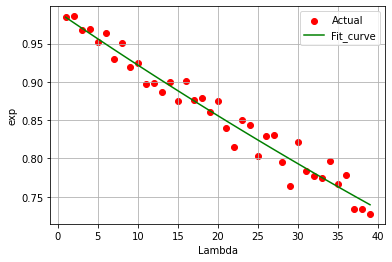

In [92]:
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt

def test(x, a, b, c):
	#return (a * x) + (b * x**2) + (c * x**3) +d
    return (a * x) + (b * x**2) +c


param, param_cov = curve_fit(test, l, res)
print("function coefficients:")
print(param)
#print("Covariance of coefficients:")
#print(param_cov)
ans=[]
for x in l:
    #ans.append ((param[0] * x) + (param[1] * x**2) + (param[2] * x**3) + (param[3])) 
    #ans.append ((param[0] * x) + (param[1] * x**2) + (param[2])) 
    ans.append ((param[0] * x) + (param[1] * x**2) + (param[2])) 
                
plt.scatter(l, res,color='r', label='Actual')     
plt.plot(l,ans,color='g', label='Fit_curve')   
plt.xlabel('Lambda')
plt.ylabel('exp')
#plt.figure(facecolor='yellow')
plt.legend()
plt.grid()
plt.show()    

In [93]:
x=0
a=param[0]
b=param[1]
c=param[2]
print(test(x, a, b, c))

0.9915658279133676


function coefficients:
[-2.02175124e-02  2.34782557e-03 -2.94036079e-04  5.11274359e-04
  3.18381721e-06 -2.77600248e-07  9.68444264e-09 -1.27319179e-10
  6.06503201e-18 -2.57210012e-23  1.00719152e+00]


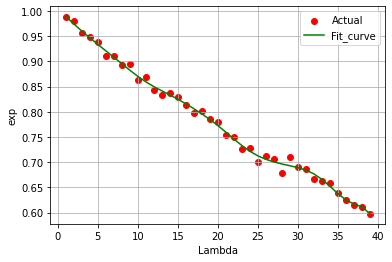

In [38]:
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt

def test(x, a, b, c, d, e, f,g,h,i,j,k):
	return (a * x) + (b * x**2) + (c * x**3) + (d * np.sin(x)) + (e * x**5) +(f * x**6) + (g * x**7) + (h * x**8)+(i * x**12) + (j * x**15)+k

param, param_cov = curve_fit(test, l, res)
print("function coefficients:")
print(param)
#print("Covariance of coefficients:")
#print(param_cov)
ans=[]
for x in l:
    ans.append ((param[0] * x) + (param[1] * x**2) + (param[2] * x**3) + (param[3] * np.sin(x)) + 
                (param[4] * x**5) ++ (param[5] * x**6)+ (param[6] * x**7)+ (param[7] * x**8)+(param[8] * x**12)+(param[9] * x**15)+ param[10])


plt.scatter(l, res,color='r', label='Actual')     
plt.plot(l,ans,color='g', label='Fit_curve')   
plt.xlabel('Lambda')
plt.ylabel('exp')
#plt.figure(facecolor='yellow')
plt.legend()
plt.grid()
plt.show()    

In [27]:
pip install mitiq

  Using cached mitiq-0.16.0-py3-none-any.whl (138 kB)
  Using cached numpy-1.20.3-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.4 MB)
  Using cached scipy-1.7.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (39.3 MB)
  Using cached cirq-0.14.1-py3-none-any.whl (7.8 kB)
  Using cached cirq_google-0.14.1-py3-none-any.whl (541 kB)
  Using cached cirq_aqt-0.14.1-py3-none-any.whl (19 kB)
  Using cached cirq_web-0.14.1-py3-none-any.whl (593 kB)
  Using cached cirq_ionq-0.14.1-py3-none-any.whl (48 kB)
  Using cached cirq_pasqal-0.14.1-py3-none-any.whl (30 kB)
  Using cached cirq_core-0.14.1-py3-none-any.whl (1.8 MB)
  Using cached cirq_rigetti-0.14.1-py3-none-any.whl (56 kB)
  Using cached sympy-1.9-py3-none-any.whl (6.2 MB)
  Using cached duet-0.2.7-py3-none-any.whl (28 kB)
  Using cached google_api_core-1.31.6-py2.py3-none-any.whl (93 kB)
  Using cached httpx-0.15.5-py3-none-any.whl (65 kB)
  Using cached qcs_api_client-0.8.0-py3-none-any.whl (97 kB)
  Using cached

In [ ]:
import qiskit
from qiskit import QuantumCircuit

# Noise simulation packages
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error

# 0.1% depolarizing noise
NOISE = 0.001

QISKIT_SIMULATOR = qiskit.Aer.get_backend("qasm_simulator")

def qs_noisy_simulation(circuit: QuantumCircuit, shots: int = 4096) -> float:
    """Runs the quantum circuit with a depolarizing channel noise model at
    level NOISE.

    Args:
        circuit (qiskit.QuantumCircuit): Ideal quantum circuit.
        shots (int): Number of shots to run the circuit
                     on the back-end.

    Returns:
        expval: expected values.
    """
    # initialize a qiskit noise model
    noise_model = NoiseModel()

    # we assume a depolarizing error for each
    # gate of the standard IBM basis
    noise_model.add_all_qubit_quantum_error(depolarizing_error(NOISE, 1), ["u1", "u2", "u3"])

    # execution of the experiment
    job = qiskit.execute(
        circuit,
        backend=QISKIT_SIMULATOR,
        basis_gates=["u1", "u2", "u3"],
        # we want all gates to be actually applied,
        # so we skip any circuit optimization
        optimization_level=0,
        noise_model=noise_model,
        shots=shots
    )
    
    results = job.result()
    counts = results.get_counts()
    shots=5000
    msg_out=msg_gss_mlt_shot(counts,shots)

    #Calcualte accuracy
    expval=0
    for key, value in msg_out.items():
        if key =='100':
            expval+=value
    expval = expval / shots
    return expval

In [10]:
#Complete Protocol for n bit message
n=99   #Ensure n is divisible by 3
message = randint(2, size = n)
msg_p=[]

ckt_lst=[]

for i in range(0,n,3):
    qc=QuantumCircuit(6,6)
    alice=[0,2,4]  #Alice qubit
    Bob=[1,3,5]  #Bob qubit

    msg=message[i:i+3] 
    msg_p.append(''.join(str(i) for i in msg))

    qc=bell_state(qc,alice)  
    qc=msg_encoding(msg,qc)
    qc=ghz_meas(qc,alice)
    qc.measure(alice,[2,1,0])
    qc.barrier()


    #Bob measurement 
    qc=ghz_meas(qc,Bob)
    qc.measure(Bob,[5,4,3])
    ckt_lst.append(qc)

#Measurement on Simulator 

M_A=[]
M_B=[]

for i in range(int(n/3)):

    result1 = simulator.run(assemble(transpile(ckt_lst[i], simulator), shots = 1, memory = True)).result()
    Bob_out=result1.get_memory()[0][:3]
    M_B.append(Bob_out)
    Alic_out=result1.get_memory()[0][3:]
    M_A.append(Alic_out)
    
print('Message={}'.format(msg_p))
print('----------------')
print('Alice_out={}'.format(M_A))  
print('----------------')
print('Bob_out={}'.format(M_B))  

msg_g=[]
for i in range(len(M_A)):
    bob_out=M_B[i]
    alic_out=M_A[i]
    msg_g.append(guess_msg(bob_out,alic_out))

#Calcualte accuracy
err=0
for i in range(len(msg_g)):
    if msg_g[i] !=msg_p[i]:
        err+=1      
print('Protocol error={}%'.format(err*100/len(M_A))) 

Message=['110', '110', '111', '011', '010', '000', '011', '110', '110', '000', '011', '010', '011', '100', '111', '110', '000', '011', '000', '011', '110', '011', '101', '001', '000', '111', '100', '011', '111', '111', '110', '000', '100']
----------------
Alice_out=['100', '100', '001', '101', '000', '010', '010', '100', '101', '000', '000', '010', '000', '110', '001', '011', '000', '110', '010', '101', '000', '011', '011', '110', '101', '110', '010', '111', '001', '110', '101', '010', '001']
----------------
Bob_out=['000', '000', '111', '100', '011', '010', '011', '000', '001', '000', '001', '001', '001', '001', '111', '111', '000', '111', '010', '100', '100', '010', '110', '100', '101', '000', '101', '110', '111', '000', '001', '010', '110']
Protocol error=0.0%


In [11]:
#On real device 
provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q-education")
device = provider.get_backend('ibmq_jakarta')
circuit=ckt_lst

from qiskit.tools.monitor import job_monitor
transpiled_circuit = transpile(circuit, device, optimization_level=3)
job = device.run(transpiled_circuit,shots = 1, memory = True)
job_monitor(job, interval=2)

Job Status: job has successfully run


In [12]:
print(job.result().get_counts())

[{'101000': 1}, {'011111': 1}, {'111101': 1}, {'010111': 1}, {'100011': 1}, {'010011': 1}, {'110001': 1}, {'111111': 1}, {'111111': 1}, {'110110': 1}, {'100001': 1}, {'101010': 1}, {'101000': 1}, {'110001': 1}, {'000001': 1}, {'110010': 1}, {'110001': 1}, {'010111': 1}, {'110000': 1}, {'010011': 1}, {'010010': 1}, {'001010': 1}, {'010011': 1}, {'010001': 1}, {'011111': 1}, {'011010': 1}, {'100001': 1}, {'011110': 1}, {'110001': 1}, {'110101': 1}, {'010110': 1}, {'000000': 1}, {'001110': 1}]


## QSDC Protocol (Noisy Simulator)

In [18]:
# This cell takes an input what kind of backend have to choose

# Create a dictionary containing backend type and corresponding user input
table={'Backend Type':['Noisy simulator (bit and phase flip)', 'Noisy simulator (depolarizing error)',
                       'Noisy simulator (thermal relaxation)', 'Real backend'],
       'Input':['NS', 'NSD', 'NST', 'RB']}

# print the dictionary as a table with keys as header
print(tabulate(table, headers='keys', tablefmt='fancy_grid'))
backend_type = input("Look at the table and enter proper input (for 'IDEAL SIMMULATOR' enter anything else): ")

╒══════════════════════════════════════╤═════════╕
│ Backend Type                         │ Input   │
╞══════════════════════════════════════╪═════════╡
│ Noisy simulator (bit and phase flip) │ NS      │
├──────────────────────────────────────┼─────────┤
│ Noisy simulator (depolarizing error) │ NSD     │
├──────────────────────────────────────┼─────────┤
│ Noisy simulator (thermal relaxation) │ NST     │
├──────────────────────────────────────┼─────────┤
│ Real backend                         │ RB      │
╘══════════════════════════════════════╧═════════╛


Look at the table and enter proper input (for 'IDEAL SIMMULATOR' enter anything else):  NS


In [19]:
# Run this cell if REAL BACKEND is choosen
# import required libraries
from qiskit import IBMQ
import qiskit.tools.jupyter
#     from qiskit.test.mock import FakeJakarta
from qiskit.providers.ibmq import least_busy
#     backend = FakeJakarta()
# Load IBM account
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-education')
backend = provider.get_backend('ibmq_jakarta') # Note that 'ibmq_jakarta' is not accessible with open goup
print(backend)
sim = provider.get_backend('ibmq_qasm_simulator')
print(sim)

ibmq_jakarta
ibmq_qasm_simulator


In [20]:
# Run this cell if NOISY SIMMULATOR (BIT and PHASE FLIP) is choosen
if 'NS' == backend_type:
    
    '''Bit-flip error is one kind of pauli error where with a small probability, p, X gate
    and with probability 1-p identity gate is being applied.
    Phase-flip error is another kind of pauli error where with a small probability, p', Z gate
    and with probability 1-p' identity gate is being applied.
    
    Here bit-flip and phase-flip error is being combined to create noisy model:
        with probability p, Z gate is being applied
        with probability p', X gate is being applied
        with probability 1-p-p', identity gate is being applied
        
        (all qubits have same error probability)'''
    
    # import required loibraries
    from qiskit.providers.aer.noise import NoiseModel
    from qiskit.providers.aer.noise.errors import pauli_error
    from qiskit.providers.aer import QasmSimulator
    
    # Error probability for reset
    x_reset = 0.008 # bit-flip probability
    z_reset = 0.011 # phase-flip probability
    
    # Error probability for measurement
    x_meas = 0.009
    z_meas = 0.013
    
    # Error probability for gate
    x_gate = 0.0004
    z_gate = 0.0005
    
    # QuantumError objects
    error_reset = pauli_error([('Z', z_reset), ('X', x_reset), ('I', 1 - x_reset - z_reset)])
    error_meas = pauli_error([('Z', z_meas), ('X', x_meas), ('I', 1 - x_meas - z_meas)])
    error_gate1 = pauli_error([('Z', z_gate), ('X', x_gate), ('I', 1 - x_gate - z_gate)])
    error_gate2 = error_gate1.tensor(error_gate1)
    
    print('Reset error:\n', error_reset, '\nMeasurement error:\n', error_meas,
          '\nSingle-qubit gate error:\n', error_gate1, '\nTwo-qubit gate error:\n', error_gate2)
    
    # Add errors to noise model
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_reset, "reset")
    noise_model.add_all_qubit_quantum_error(error_meas, "measure")
    noise_model.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"])
    
    backend = QasmSimulator(noise_model = noise_model)
    
    print(noise_model)

Reset error:
 QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.011, Circuit = 
   ┌───┐
q: ┤ Z ├
   └───┘
  P(1) = 0.008, Circuit = 
   ┌───┐
q: ┤ X ├
   └───┘
  P(2) = 0.981, Circuit = 
   ┌───┐
q: ┤ I ├
   └───┘ 
Measurement error:
 QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.013, Circuit = 
   ┌───┐
q: ┤ Z ├
   └───┘
  P(1) = 0.009, Circuit = 
   ┌───┐
q: ┤ X ├
   └───┘
  P(2) = 0.978, Circuit = 
   ┌───┐
q: ┤ I ├
   └───┘ 
Single-qubit gate error:
 QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.0005, Circuit = 
   ┌───┐
q: ┤ Z ├
   └───┘
  P(1) = 0.0004, Circuit = 
   ┌───┐
q: ┤ X ├
   └───┘
  P(2) = 0.9991000000000001, Circuit = 
   ┌───┐
q: ┤ I ├
   └───┘ 
Two-qubit gate error:
 QuantumError on 2 qubits. Noise circuits:
  P(0) = 2.4999999999999994e-07, Circuit = 
     ┌───┐
q_0: ┤ Z ├
     ├───┤
q_1: ┤ Z ├
     └───┘
  P(1) = 1.9999999999999996e-07, Circuit = 
     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ Z ├
     └───┘
  P(2) = 0.00049955, Circuit = 
     ┌───┐
q_0:

In [21]:
# Run this cell if NOISY SIMMULATOR (KRAUS ERROR) is choosen

# It creates noise model implementing kraus error

if 'NSK' == backend_type:
    # import required libraries
    from qiskit.providers.aer.noise import NoiseModel
    from scipy.stats import unitary_group
    from qiskit.providers.aer.noise.errors import kraus_error
    from qiskit.providers.aer import QasmSimulator
    
    # QuantumError objects
    error_reset = kraus_error([unitary_group.rvs(2)])
    error_meas = kraus_error([unitary_group.rvs(2)])
    error_gate1 = kraus_error([unitary_group.rvs(2)])
    error_gate2 = kraus_error([unitary_group.rvs(4)])
    
    print('\nReset error:\n', error_reset, '\nMeasurement error:\n', error_meas,
          '\nSingle-qubit gate error:\n', error_gate1, '\nTwo-qubit gate error:\n', error_gate2)
    
    # Add errors to noise model
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_reset, "reset")
    noise_model.add_all_qubit_quantum_error(error_meas, "measure")
    noise_model.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"])
    
    backend = QasmSimulator(noise_model = noise_model)
    
    print('\n', noise_model)

In [22]:
# Run this cell if NOISY SIMMULATOR (DEPOLARIZING ERROR) is choosen

# It creates noise model implementing depolarizing error

if 'NSD' == backend_type:
    
    # import required libraries
    from qiskit.providers.aer.noise import NoiseModel
    from qiskit.providers.aer.noise.errors import depolarizing_error
    from qiskit.providers.aer import QasmSimulator
    
    # QuantumError objects
    lambd = rand() * 0.01
#     error_reset = depolarizing_error(lambd, 1)
#     error_meas = depolarizing_error(lambd, 1)
    error_gate1 = depolarizing_error(lambd, 1)
#     error_gate2 = depolarizing_error(lambd, 2)
    
#     print('\nReset error:\n', error_reset, '\nMeasurement error:\n', error_meas,
#           '\nSingle-qubit gate error:\n', error_gate1, '\nTwo-qubit gate error:\n', error_gate2)
    
    # Add errors to noise model
    noise_model = NoiseModel()
#     noise_model.add_all_qubit_quantum_error(error_reset, "reset")
#     noise_model.add_all_qubit_quantum_error(error_meas, "measure")
    noise_model.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
#     noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"])
    
    backend = QasmSimulator(noise_model = noise_model)
    
    print('\n', noise_model)
    
    print('lambda = ', lambd)

In [23]:
def dnoise_backend(lambd):
    # import required libraries
    from qiskit.providers.aer.noise import NoiseModel
    from qiskit.providers.aer.noise.errors import depolarizing_error
    from qiskit.providers.aer import QasmSimulator
    
    # QuantumError objects
#     lambd = rand() * 0.01
    error = depolarizing_error(lambd, 1)
#     error_meas = depolarizing_error(lambd, 1)
#     error_gate1 = depolarizing_error(lambd, 1)
    error_gate2 = depolarizing_error(lambd, 2)
    
    print(error, error_gate2)
    
#     print('\nReset error:\n', error_reset, '\nMeasurement error:\n', error_meas,
#           '\nSingle-qubit gate error:\n', error_gate1, '\nTwo-qubit gate error:\n', error_gate2)
    
    # Add errors to noise model
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error, ["reset", "measure", "u1", "u2", "u3"])
#     noise_model.add_all_qubit_quantum_error(error_meas, "measure")
#     noise_model.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"])
    
    return QasmSimulator(noise_model = noise_model)

In [24]:
# Run this cell if NOISY SIMMULATOR (THERMAL RELAXATION) is choosen

# It creates noise model implementing thermal relaxion error

if 'NST' == backend_type:
    # import required libraries
    from qiskit.providers.aer.noise import NoiseModel
    from qiskit.providers.aer.noise.errors import thermal_relaxation_error
    from qiskit.providers.aer import QasmSimulator
    
    n_qubits = 3 # number of qubits
    
    # T1 (relaxation time) and T2 (dephasing time) values for qubits
    T1s = normal(160e3, 10e3, n_qubits) # Sampled from normal distribution mean 160 microsec
    T2s = normal(150e3, 10e3, n_qubits) # Sampled from normal distribution mean 150 microsec
    
    # Truncate random T2s <= 2*T1s
    T2s = array([min(T2s[j], 2 * T1s[j]) for j in range(n_qubits)])
    
    # Instruction times (in nanoseconds) for gates
    time_u1 = 100
    time_u2 = 150
    time_u3 = 150
    time_cx = 300
    time_reset = 1000  # 1 microsecond
    time_measure = 1000 # 1 microsecond
    
    # QuantumError objects
    errors_reset = [thermal_relaxation_error(t1, t2, time_reset) for t1, t2 in zip(T1s, T2s)]
    errors_measure = [thermal_relaxation_error(t1, t2, time_measure) for t1, t2 in zip(T1s, T2s)]
    errors_u1  = [thermal_relaxation_error(t1, t2, time_u1) for t1, t2 in zip(T1s, T2s)]
    errors_u2  = [thermal_relaxation_error(t1, t2, time_u2) for t1, t2 in zip(T1s, T2s)]
    errors_u3  = [thermal_relaxation_error(t1, t2, time_u3) for t1, t2 in zip(T1s, T2s)]
    errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)] for t1b, t2b in zip(T1s, T2s)]
    
    # Add errors to noise model
    noise_model = NoiseModel()
    for j in range(n_qubits):
        noise_model.add_quantum_error(errors_reset[j], "reset", [j])
        noise_model.add_quantum_error(errors_measure[j], "measure", [j])
        noise_model.add_quantum_error(errors_u1[j], "u1", [j])
        noise_model.add_quantum_error(errors_u2[j], "u2", [j])
        noise_model.add_quantum_error(errors_u3[j], "u3", [j])
        for k in range(n_qubits):
            noise_model.add_quantum_error(errors_cx[j][k], "cx", [j, k])
    
    backend = QasmSimulator(noise_model = noise_model)
    
    print(noise_model)

In [25]:
def noise_backend(t1, t2, time_readout, time_single, time_cx):
    # import required libraries
    from qiskit.providers.aer.noise import NoiseModel
    from qiskit.providers.aer.noise.errors import thermal_relaxation_error
    from qiskit.providers.aer import QasmSimulator
    
    # QuantumError objects
    error_measure = thermal_relaxation_error(t1, t2, time_readout)
    error_single  = thermal_relaxation_error(t1, t2, time_single)
    error_cx = thermal_relaxation_error(t1, t2, time_cx).expand(thermal_relaxation_error(t1, t2, time_cx))
    
    print('\nMeasurement error:\n', error_measure,
          '\nSingle-qubit gate error:\n', error_single, '\nTwo-qubit gate error:\n', error_cx)
    
    # Add errors to noise model
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_measure, ["measure", "reset"])
    noise_model.add_all_qubit_quantum_error(error_single, ["u1", "u2", "u3", "rz", "sx"])
    noise_model.add_all_qubit_quantum_error(error_cx, ["cx"])
    
    return QasmSimulator(noise_model = noise_model)

## QSDC Protocol (with attacks)

In [26]:
# For Entangle-and-measure attack
def entgl(qc, qubits):
    '''Create entanglement between circuit qubits and some ancilla qubits.
    Arguments:
        seq: a list of quantum circuit
        qubits: list of qubits to entangle'''
    num = len(qubits)
    num_q = qc.num_qubits # number of qubits in circuit
    anc = QuantumRegister(num) # create ancillary registers
    qc.add_register(anc) # add ancilary registers
    for (qubit, i) in zip(qubits, range(num)):
        # Create entanglement
        qc.cx(qubit, num_q + i)
    qc.barrier()
    return(qc) 


In [27]:
# For DoS attack
def app_uni(qc, qubits):
    '''Randomly applies identity on half of the circuits and
    other unitary operations for other half of the circuits.
    Arguments:
        seq: a list of quantum circuit
        qubits: list of qubits to apply unitary (or identity)'''
    if 1 == randint(2):
        for qubit in qubits:
            # 𝜃,𝜙,𝜆 varies between 0 and 2𝜋
            theta  = 2 * pi * rand()
            phi = 2 * pi * rand()
            lamb = 2 * pi * rand()
            qc.u(theta, phi, lamb, qubit)
        qc.barrier()
        
    return(qc)   

In [28]:
def iterate(message, n, attack,simulator, coupling_map = None, noise_model = None):

    msg_p=[]
    ckt_lst=[]
   
    for i in range(0,n,3):
        
        qc=QuantumCircuit(6,6)
        alice=[0,2,4]  #Alice qubit
        Bob=[1,3,5]  #Bob qubit

        msg=message[i:i+3] 
        msg_p.append(''.join(str(i) for i in msg))
        

        qc=bell_state(qc,alice)  
        qc=msg_encoding(msg,qc)
        
        # ENTANGLEMENT
        if attack == 'EM':
            qc=entgl(qc, alice)

        # DoS
        if attack == 'DoS':
            qc=app_uni(qc, alice)
        
        qc=ghz_meas(qc,alice)
        qc.measure(alice,[2,1,0])
        qc.barrier()

        #Bob measurement 
        qc=ghz_meas(qc,Bob)
        qc.measure(Bob,[5,4,3])
        
        ckt_lst.append(qc)

    #Measurement on Simulator 

    result=[]
    for i in range(int(n/3)):
        result1 = simulator.run(assemble(transpile(ckt_lst[i], simulator), shots = 1024, memory = True)).result()
        result.append(result1.get_counts())

    msg_out=msg_gss_mlt_shot(result)

    def get_key(my_dict,val):
        for key, value in my_dict.items():
             if val == value:
                    return key
        return "key doesn't exist"

    #Calcualte accuracy
    err=0
    for i in range(len(msg_p)):
        #msg_g=get_key(msg_out[i],max(msg_out[i].values()))
        for key, value in msg_out[i].items():
            if key !=msg_p[i]:
                err+=value      
    return(err/len(msg_p))

In [29]:
#Without attack 

n=99   #Ensure n is divisible by 3
message = randint(2, size = n)
#print(message)
dct_prcnt=[]
itrn = int(input("Number of iteration: "))
for itr in range(itrn):
    print('\rRunning iteration number:',itr+1,end='')
    a=iterate(message, n, None, backend, coupling_map = None, noise_model = None)
    dct_prcnt.append(a)
    
avg_percnt = mean(dct_prcnt)    
var = variance(dct_prcnt)
print('')
print('Average error', avg_percnt)
print('Variance of error', var) 
    
       

Number of iteration:  10


Running iteration number: 10
Average error 6.571377840909091
Variance of error 0.03902309586254746


10


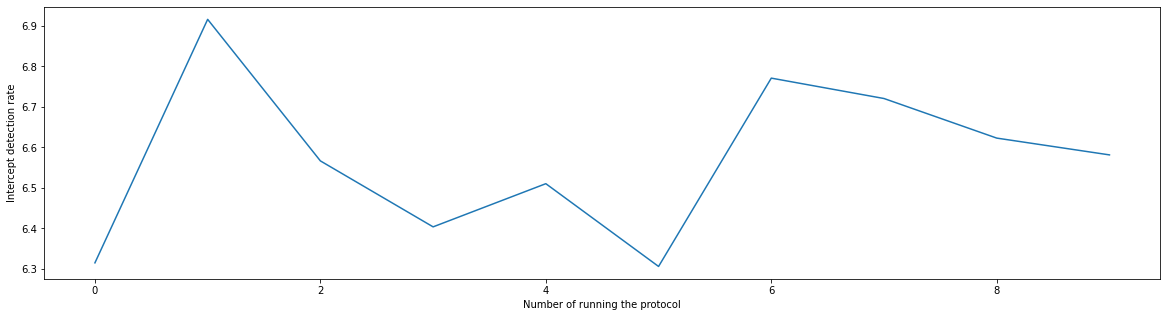

In [30]:
# Plot percentage of intercept detection vs number of running the protocol
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))
size = len(dct_prcnt)

print(size)

plt.plot(range(size), dct_prcnt)
plt.xlabel('Number of running the protocol')
plt.ylabel('Intercept detection rate')
plt.show()

In [31]:
# with EM ATTACK

n=99   #Ensure n is divisible by 3
message = randint(2, size = n)
dct_prcnt=[]
itrn = int(input("Number of iteration: "))
for itr in range(itrn):
    print('\rRunning iteration number:',itr+1,end='')
    dct_prcnt.append(iterate(message, n, 'EM', backend, coupling_map = None, noise_model = None))
    
avg_percnt = mean(dct_prcnt)
var = variance(dct_prcnt)
print('')
print('Average error', avg_percnt)
print('Variance of error', var)  

Number of iteration:  10


Running iteration number: 10
Average error 52.011422821969695
Variance of error 0.05239039680785323


10


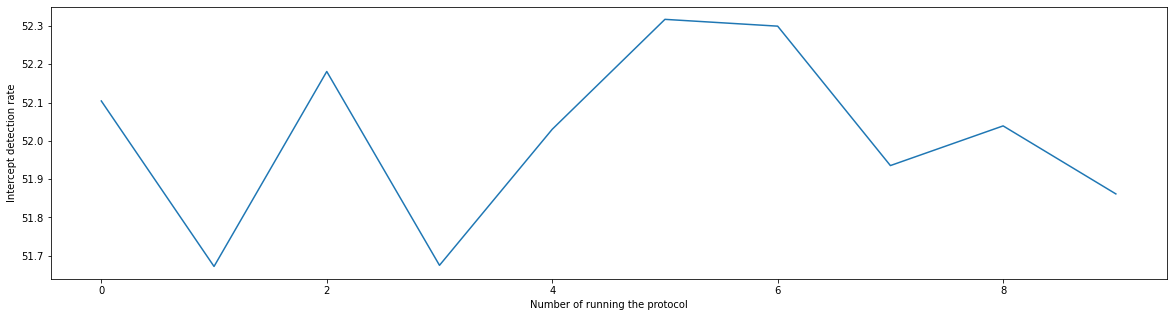

In [32]:
# Plot percentage of intercept detection vs number of running the protocol
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))
size = len(dct_prcnt)

print(size)

plt.plot(range(size), dct_prcnt)
plt.xlabel('Number of running the protocol')
plt.ylabel('Intercept detection rate')
plt.show()

In [33]:
# with DOS ATTACK

n=99   #Ensure n is divisible by 3
message = randint(2, size = n)
dct_prcnt=[]
itrn = int(input("Number of iteration: "))
for itr in range(itrn):
    print('\rRunning iteration number:',itr+1,end='')
    dct_prcnt.append(iterate(message, n, 'DoS', backend,  coupling_map = None, noise_model = None))
    
avg_percnt = mean(dct_prcnt)
var = variance(dct_prcnt)
print('')
print('Average error', avg_percnt)
print('Variance of error', var)  

Number of iteration:  10


Running iteration number: 10
Average error 47.878787878787875
Variance of error 67.08684749426178


10


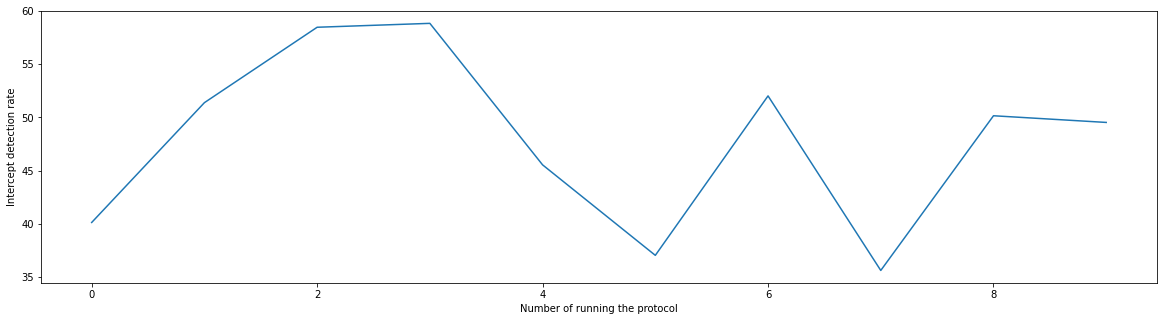

In [34]:
# Plot percentage of intercept detection vs number of running the protocol
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))
size = len(dct_prcnt)

print(size)

plt.plot(range(size), dct_prcnt)
plt.xlabel('Number of running the protocol')
plt.ylabel('Intercept detection rate')
plt.show()

## Simulation on Noisy simulator with Real Backend properties 

In [35]:
## Important - this code works!
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import device
from qiskit import IBMQ
from qiskit.providers.aer import QasmSimulator

provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q-education")
Real_backend = provider.get_backend('ibmq_jakarta')

props = Real_backend.properties()

ibmqfactory.load_account:WARNING:2022-06-13 05:32:08,466: Credentials are already in use. The existing account in the session will be replaced.


In [36]:
#Get all parameters
readout_error_params = device.basic_device_readout_errors(props)
readout_error_vals = device.readout_error_values(props)
quantum_errors = device.basic_device_gate_errors(props)
param_error_values = device.gate_param_values(props)
gate_error_vals = device.gate_error_values(props)
gate_length = device.gate_length_values(props)
thermal_relax_vals = device.thermal_relaxation_values(props)

In [37]:
noise_model = NoiseModel()

#Adding readout errors
for qubit, error in readout_error_params:
    noise_model.add_readout_error(error, qubit)

#Adding all quantum errors
for instr, qubit, error in quantum_errors:
    noise_model.add_quantum_error(error, instr, qubit)

backend1 = QasmSimulator(noise_model = noise_model)    

In [38]:
#Without attack 

n=99   #Ensure n is divisible by 3
message = randint(2, size = n)
#print(message)
dct_prcnt=[]
itrn = int(input("Number of iteration: "))
for itr in range(itrn):
    print('\rRunning iteration number:',itr+1,end='')
    a=iterate(message, n, None, backend1, coupling_map = None, noise_model = None)
    dct_prcnt.append(a)
    
avg_percnt = mean(dct_prcnt)    
var = variance(dct_prcnt)
print('')
print('Average error', avg_percnt)
print('Variance of error', var) 
    

Number of iteration:  10


Running iteration number: 10
Average error 18.959517045454547
Variance of error 0.09665339835480001
